In [1]:
import numpy as np
import pandas as pd

import anndata as ad
import scanpy as sc

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as clr
from matplotlib.pyplot import rc_context

c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
sc.settings.n_jobs = 12

In [3]:
import torch
torch.set_float32_matmul_precision('high')
torch.cuda.is_available()

True

In [4]:
from lightning.pytorch import seed_everything
seed_everything(12345)

Seed set to 12345


12345

In [5]:
import scvi

c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\docrep\decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\docrep\decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [6]:
sample_info = pd.read_csv('../../data/merfish/BAYSOR/qc/baysor_sample_qc_metrics_annotated.csv', index_col=0)
adata = sc.read_h5ad("../../data/merfish/BAYSOR/seurat_objects/ns-atlas.baysor_segmentation_filtered.anndata_object.h5ad")

In [7]:
del adata.layers['log1p']
del adata.obsm['X_pca']
del adata.obsm['X_umap']
del adata.layers['scaled']

In [8]:
barcodes = adata.obs_names.values.tolist()

In [9]:
meta = adata.obs.copy()
meta['cell_barcode'] = meta.index.values.tolist()
meta = meta.merge(sample_info, on='sample_id', how = 'inner')
barcodes = meta['cell_barcode'].values.astype('str').tolist()
meta.index = barcodes

In [10]:
adata = adata[barcodes, :].copy()
adata.obs = meta

In [11]:
cat_cols = adata.obs.select_dtypes(exclude=["number","bool_","object_"]).columns.tolist()
for cat in cat_cols:
    adata.obs[cat] = adata.obs[cat].astype("str").values.tolist()

In [12]:
adata.layers['counts'][np.isnan(adata.layers['counts'])] = 0
adata.X = adata.layers['counts'].copy()

In [13]:
sc.pp.filter_cells(adata, min_counts=10)

In [14]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers['log1p'] = adata.X.copy()
sc.pp.scale(adata)
adata.layers['scaled'] = adata.X.copy()

In [15]:
sc.pp.highly_variable_genes(adata, layer='log1p', n_top_genes=500, batch_key = 'sample_barcode', subset=False)

In [16]:
panel_info = pd.read_csv("../../data/reference/gene_panel.csv")
panel_info.index = panel_info['gene_symbol'].values.tolist()
panel_info = panel_info.loc[adata.var.index.values]
panel_info["in_both_panels"] = np.array([panel == "Both" for panel in panel_info['gene_panel']])
adata.var = pd.concat([adata.var, panel_info], axis=1)

In [17]:
adata.var.to_csv("../../data/merfish/BAYSOR/seurat_objects/ns-atlas.merfish_baysor.scvi_integrated.gene_data.csv")

In [18]:
adata.var[['highly_variable', 'in_both_panels']].value_counts().unstack()

in_both_panels   False  True 
highly_variable              
False             62.0    NaN
True              66.0  434.0

In [19]:
full_adata = adata.copy()
adata = adata[:, adata.var['in_both_panels']].copy()

In [20]:
adata.obs['sample_barcode'] = adata.obs['sample_barcode'].astype("category").values.tolist()

In [21]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="sample_barcode", categorical_covariate_keys=['gene_panel', 'collection_source'], continuous_covariate_keys=['transcript_count'])
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")
model.train(accelerator='gpu')
model.save("../../data/merfish/BAYSOR/merfish_scvi_model", overwrite=True)

c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\scvi\model\_scvi.py:159: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 7/7: 100%|██████████| 7/7 [07:20<00:00, 62.86s/it, v_num=1, train_loss_step=61.2, train_loss_epoch=67.4]

`Trainer.fit` stopped: `max_epochs=7` reached.


Epoch 7/7: 100%|██████████| 7/7 [07:20<00:00, 62.94s/it, v_num=1, train_loss_step=61.2, train_loss_epoch=67.4]


In [22]:
adata.obsm['scvi'] = model.get_latent_representation()

In [23]:
sc.pp.neighbors(adata, use_rep = 'scvi', n_pcs=30, n_neighbors=30, random_state=12345)
sc.tl.umap(adata, min_dist=0.1, negative_sample_rate=10, key_added='scvi_umap', random_state=12345)

In [24]:
full_adata.obsm['scvi'] = adata.obsm['scvi'].copy()
full_adata.obsm['scvi_umap'] = adata.obsm['scvi_umap'].copy()

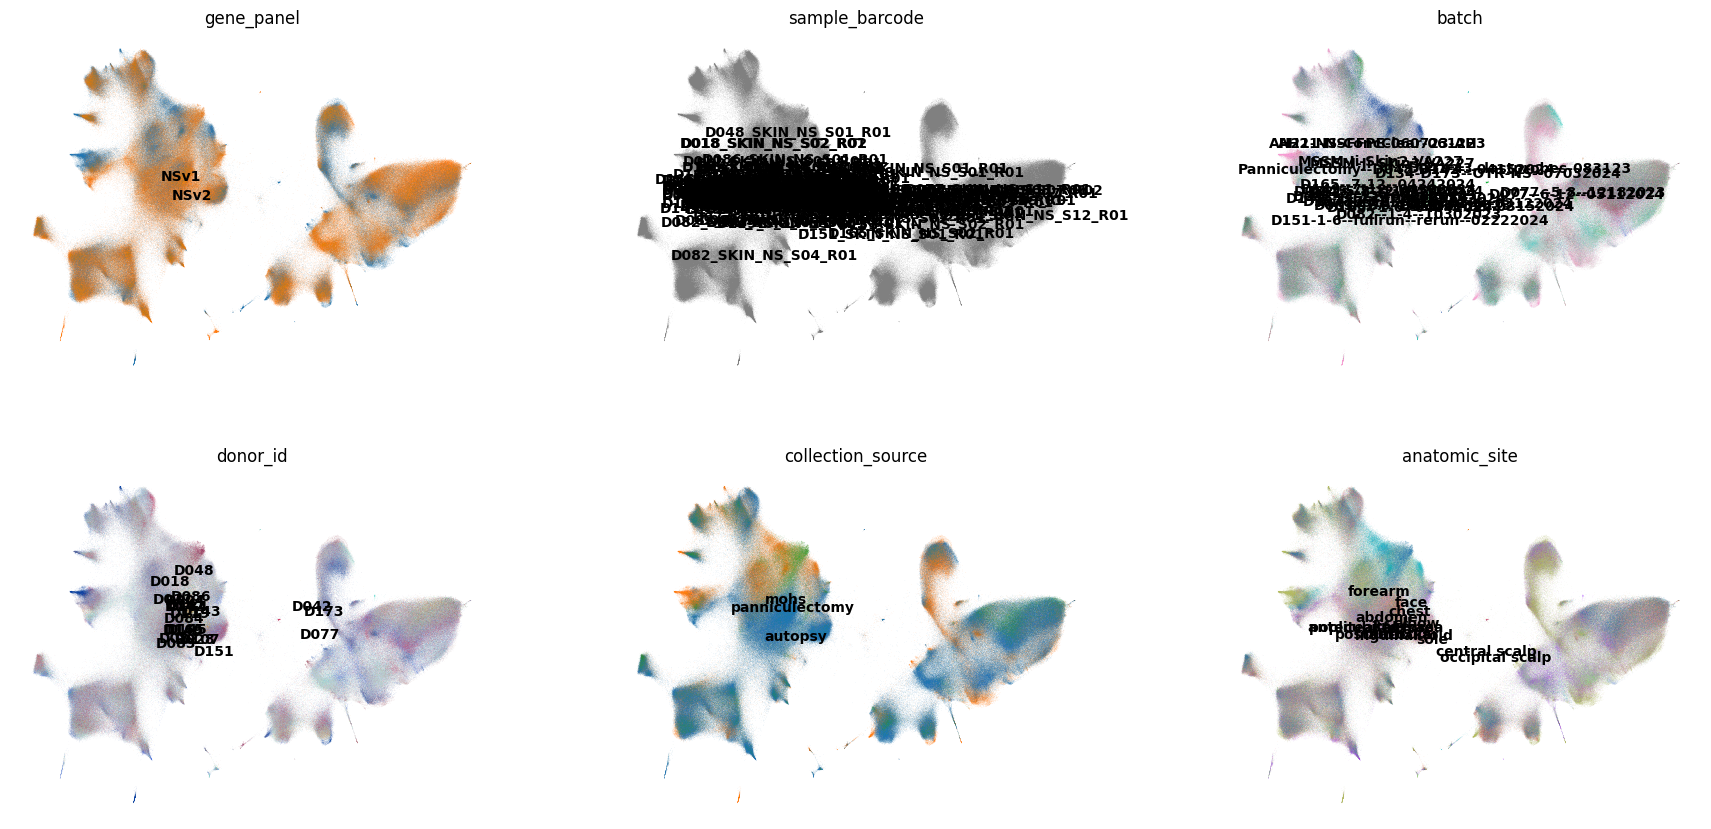

In [25]:
sc.pl.embedding(adata, basis='scvi_umap', color=["gene_panel", "sample_barcode", "batch", "donor_id", "collection_source", "anatomic_site"], frameon=False, ncols=3, legend_loc='on data')

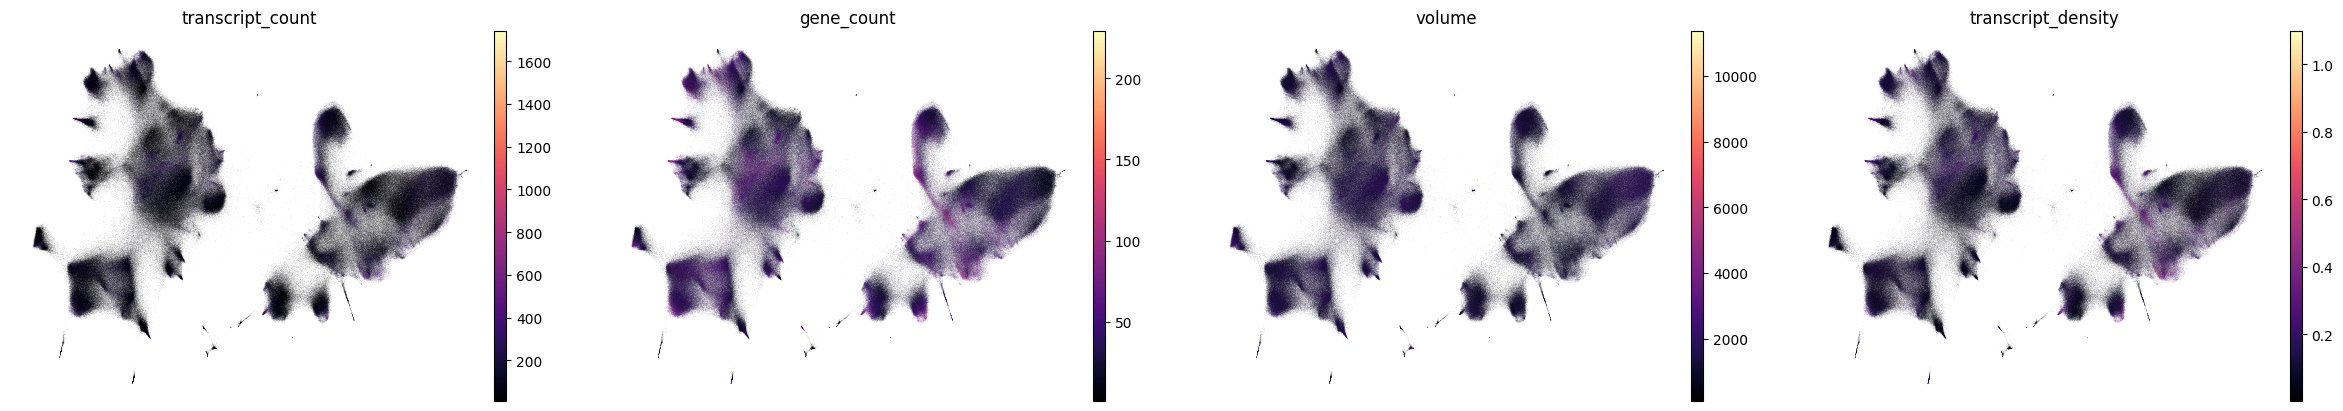

In [43]:
sc.pl.embedding(adata, basis='scvi_umap', color=["transcript_count", "gene_count", "volume", "transcript_density"], frameon=False, ncols=4, cmap='magma')

In [30]:
batches = np.unique(adata.obs['batch'].values).tolist()
batches

['AH21-NS-ConcClear-061223',
 'AH21-NSFFPE-060723-AH',
 'AutopsyBFFPE092823',
 'D041-43--lastprobes-083123',
 'D077--1-4--12132023',
 'D077--5-8--12182023',
 'D077--6-12--05112024',
 'D082--1-4--10302023',
 'D082--4-12--05082024',
 'D082--5-8--11012023',
 'D083--1-6-032124',
 'D107--1-6--03122024',
 'D107--7-12--03182024',
 'D134-D173--OTR-NS--07032024',
 'D145--1-6--03282024',
 'D145--7-12--04112024',
 'D149--1-6--rerun--05142024',
 'D149--7-12--04302024',
 'D151--7-12--03152024',
 'D151-1-6--fullrun--rerun--02222024',
 'D165--1-6--04042024',
 'D165--7-12--04242024',
 'MSSM-Ji-Skin2-VA227',
 'MSSM-Ji-Skin3-VA227',
 'Panniculectomy--D048-D142---04152024']

In [32]:
new_batches = [f'MSSM_{i:02}' for i in range(0, len(batches))]
new_batches

['MSSM_00',
 'MSSM_01',
 'MSSM_02',
 'MSSM_03',
 'MSSM_04',
 'MSSM_05',
 'MSSM_06',
 'MSSM_07',
 'MSSM_08',
 'MSSM_09',
 'MSSM_10',
 'MSSM_11',
 'MSSM_12',
 'MSSM_13',
 'MSSM_14',
 'MSSM_15',
 'MSSM_16',
 'MSSM_17',
 'MSSM_18',
 'MSSM_19',
 'MSSM_20',
 'MSSM_21',
 'MSSM_22',
 'MSSM_23',
 'MSSM_24']

In [33]:
adata.obs['run_name.short'] = adata.obs['batch']

In [34]:
adata.obs['batch'] = adata.obs['batch'].astype("category").map(dict(zip(batches, new_batches))).values.tolist()

c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\scanpy\plotting\_utils.py:1352: FutureWarning: `scale` is deprecated, use `density_norm` instead
  warnings.warn(msg, FutureWarning)


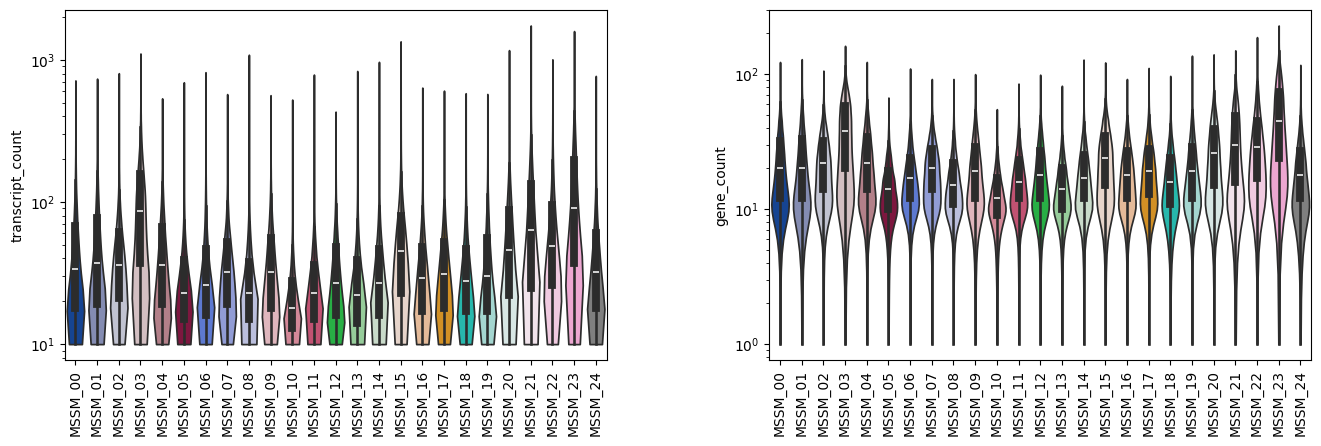

In [40]:
sc.pl.violin(adata, groupby='batch', keys=['transcript_count', 'gene_count'],
             rotation=90, stripplot=False, scale='width', log=True, inner="box")

In [44]:
resolutions = [0.2, 0.4, 0.5, 0.6, 0.8, 1, 1.5, 2, 2.5]
for res in resolutions:
    sc.tl.leiden(adata, resolution = res, key_added=f'scvi.leiden_{res}', n_iterations=2, random_state=12345)
    print(res)

0.2
0.4
0.5
0.6
0.8
1
1.5
2
2.5


In [45]:
full_adata.obs = adata.obs.copy()

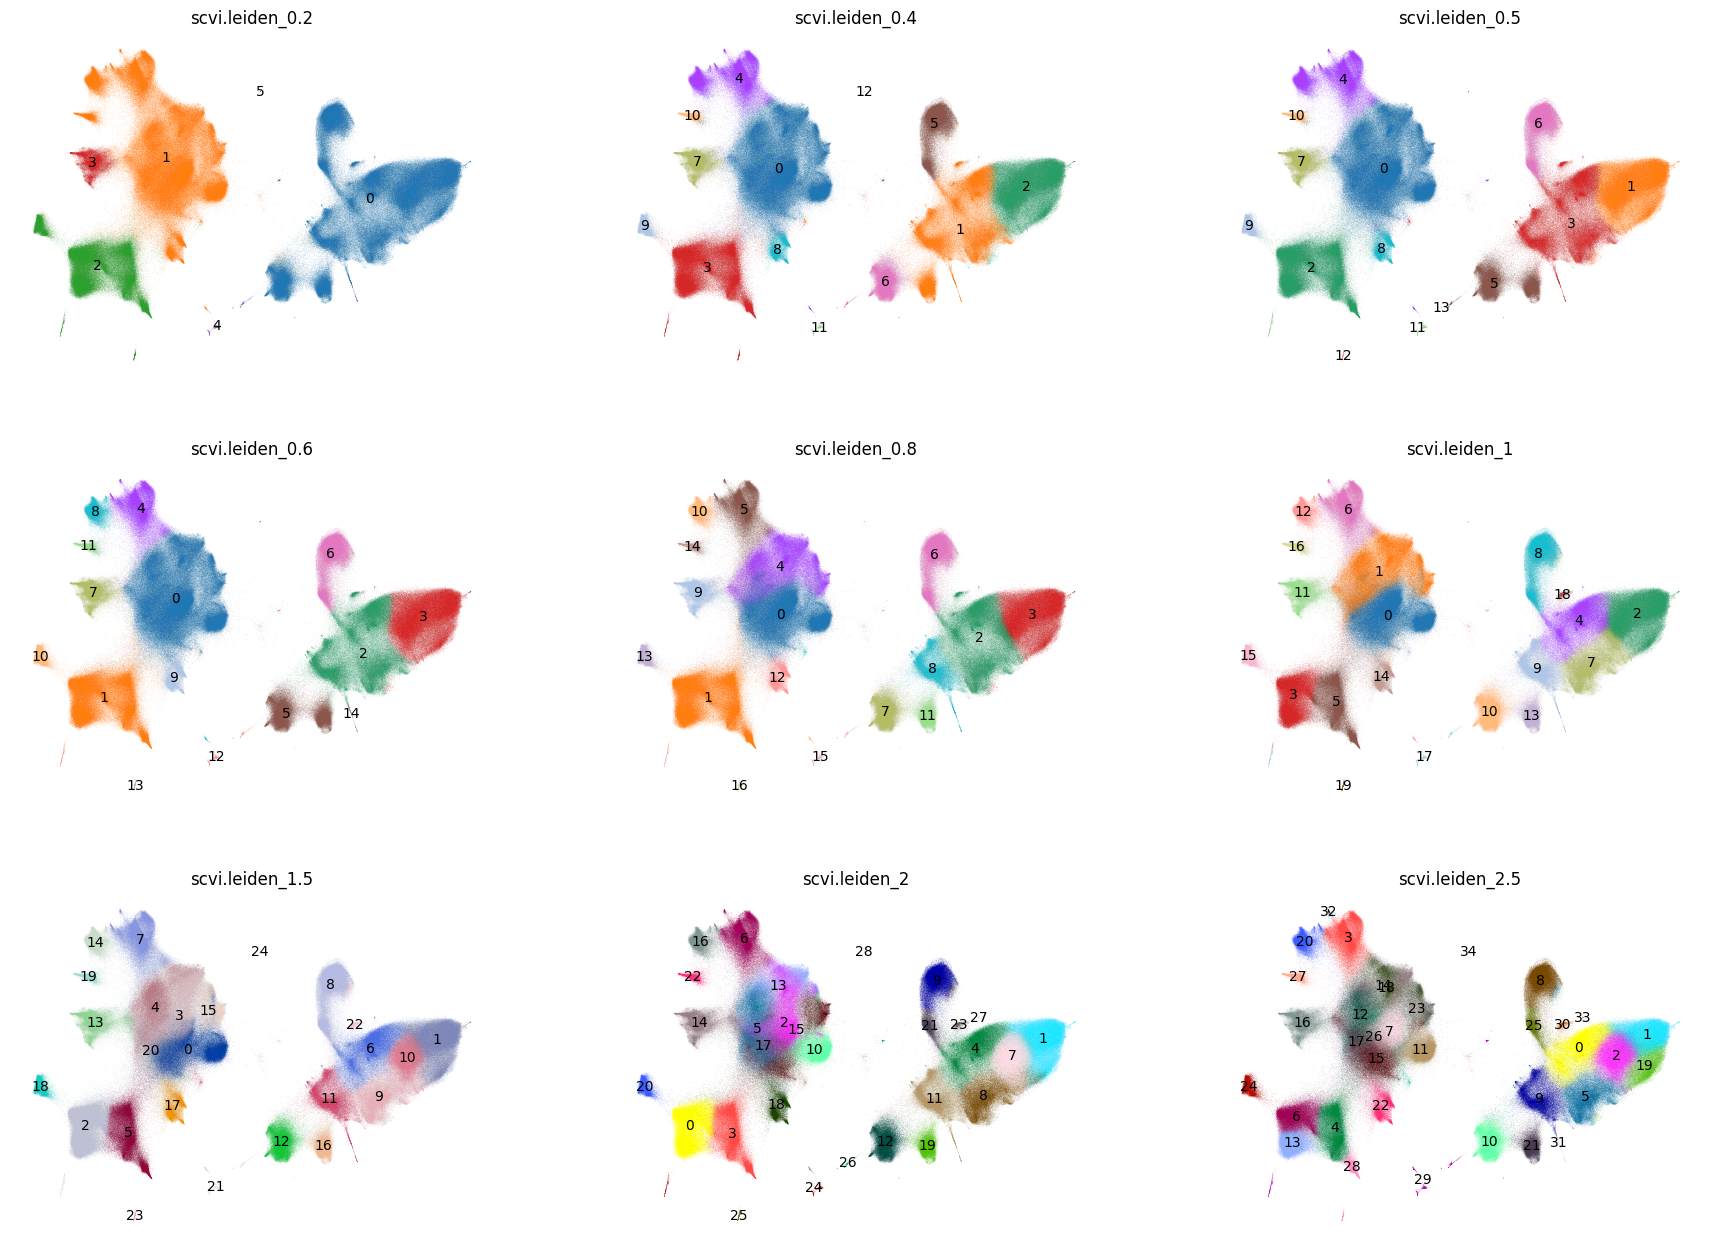

In [52]:
res_cols = [f'scvi.leiden_{res}' for res in resolutions]
with rc_context():
    sc.pl.embedding(adata, basis='scvi_umap', color=res_cols, frameon=False, ncols=3, legend_loc='on data', legend_fontweight='normal')

In [47]:
adata = full_adata.copy()
del full_adata

In [89]:
scanvi_query = scvi.model.SCANVI.load_query_data(adata, "../../data/scrna/scanvi_reference_model")
scanvi_query.train(accelerator='gpu', max_epochs=20)

INFO     File ../../data/scrna/scanvi_reference_model\model.pt already downloaded                                  
INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 20/20: 100%|██████████| 20/20 [34:38<00:00, 99.18s/it, v_num=1, train_loss_step=91.8, train_loss_epoch=96.7] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [34:38<00:00, 103.93s/it, v_num=1, train_loss_step=91.8, train_loss_epoch=96.7]


In [90]:
adata.obsm["scrna_scanvi"] = scanvi_query.get_latent_representation()
adata.obs["scrna_predicted_id"] = scanvi_query.predict()

In [91]:
adata.write_h5ad("../../data/merfish/BAYSOR/seurat_objects/ns-atlas.merfish_baysor.scvi_integrated.anndata.h5ad")

In [92]:
adata.obs.to_csv("../../data/merfish/BAYSOR/seurat_objects/ns-atlas.merfish_baysor.scvi_integrated.cell_metadata.csv")

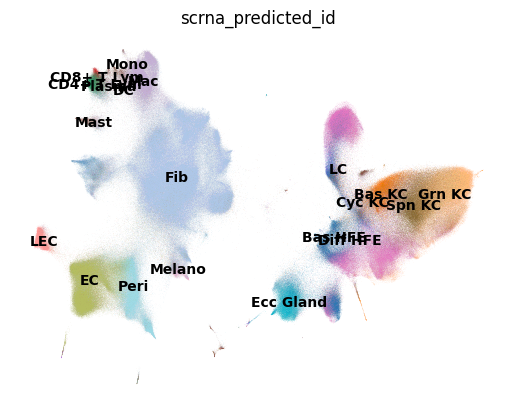

In [93]:
sc.pl.embedding(adata, basis='scvi_umap', color=["scrna_predicted_id"], legend_loc='on data', ncols=1, frameon=False)

In [68]:
import seaborn as sns
gray2blue = sns.blend_palette([sns.xkcd_rgb["light grey"], sns.xkcd_rgb["electric blue"]], as_cmap=True)

In [72]:
def filter_markers_by_genes(marker_dict, detected_genes):
    """
    Filters each cell type's marker list to only include genes detected in the expression matrix.

    Args:
        marker_dict (dict): Dictionary of cell type → list of marker genes.
        detected_genes (iterable): List or set of gene names detected in expression matrix.

    Returns:
        dict: Filtered marker dictionary.
    """
    detected_genes_set = set(detected_genes)
    filtered_dict = {
        cell_type: [gene for gene in markers if gene in detected_genes_set]
        for cell_type, markers in marker_dict.items()
    }
    return filtered_dict

In [73]:
cell_type_markers = {
    "Adipo": ["ADIPOQ", "LRP1", "THY1", "CD34", "CD44", "ICAM1", "CD90"],

    "Schwann": ["NRXN1", "MPZ"],
    "Neuron": ["CACNA1B", "NEFH", "SNAP25", "TAC1", "SLITRK6"],
    "Merkel": ["VIP", "KRT20", "CHGA", "PCP4"],

    "LEC": ["LYVE1", "ANGPT2", "CCL21"],
    "VEC": ["VWF", "FLT1", "KDR"],
    "HEC": ["ACKR1"],
    "Peri": ["ACTA2", "RGS5", "TCIM", "RGS16", "PDGFRB"],
    "SM": ["DES", "MCAM", "MYH11"],

    "Fib": ["PDGFRA", "COL1A1"],
    "Papil Fib": ["COMP", "COL18A1", "WIF1"],
    "Perivasc Fib": ["APOE", "CCL19", "PI16", "FN1", "CCDC80", "CXCL12"],
    "Retic Fib I/II": ["PRG4", "MMP2", "SFRP2"],  # PRG4+: Retic I; PRG4-: Retic II
    "Retic Fib III": ["THBS4", "CLU", "LUM", "ANGPTL7"],
    "Retic Fib IV": ["SFRP1", "APOD", "PTGDS", "TNNC1", "FOXD1", "TAGLN"],

    "DP": ["COCH", "CRABP1", "FIBIN", "PLXDC1"],
    "DS": ["ACAN", "COL11A1", "DPEP1", "LRRC15", "MYL4", "TNN", "ITGA8"],

    "T Cell": ["CD3E", "CD3D", "CD3G", "HLA-DRB5", "CD4", "CD8A"],  # control
    "NK": ["NKG7", "NCR1", "GNLY"],
    "Cytotoxic": ["GZMK", "GZMA", "GZMH", "GZMB", "GZMM"],  # activation
    "Exhaustion": ["PDCD1", "CTLA4"],
    "Naive": ["IL2RG", "SELL"],  # IL2RG=CD132; CD62L=SELL
    "T Naive": ["IL7R", "CCR7", "S100A4"],  # Naive CD4+ T / Memory CD4+
    "T Reg": ["FOXP3", "IL10"],
    "T Help": ["IL9", "RORC", "STAT2", "STAT6", "TBX21"],
    
    "B Cell": ["CD19", "MS4A1", "CD27", "CD38"],  # B cells
    "B Naive": ["IL4R", "IGHD", "CD69", "IGHM"],  # Naive
    "Plasma": ["MZB1", "IGHG1", "IGHG2", "IGHG3", "IGHG4", "IGHA1", "IGHA2", "JCHAIN", "XBP1"],  # plasma
    
    "ILC1": ["IL6R", "CXCR3", "BCL11B"],
    "ILC2": ["KLRG1", "GATA3", "PTGDR2", "SLAMF1"],
    "ILC3": ["IL23R", "XCL1", "XCL2"],  # IL3 when CD69+ and IL7R+
    "DC": ["CD11B", "CD103", "CD80", "CD86", "CD40"],
    "cDC1": ["CD141", "CLEC9A", "ITGAE", "ITGAX", "THBD", "XCR1", "BATF3"],  # migDCs
    "cDC2": ["CD1C", "CLEC10A", "CD163", "IRF4", "IRF8"],
    "pDC": ["IL3RA", "CD45RA", "IRF7"],
    "LC": ["CD207", "CD1A", "S100B"],
    
    "Mono": ["CD14", "C5AR1", "LYZ", "FCGR3A", "MS4A7"],
    "Mac": ["C1QA", "C1QB", "CD68", "CSF1R", "MRC1"],
    "Mast": ["IL1RL1", "KIT", "HDC"],
    
    "HF/HS/IRS": ["KRT83", "LGR5", "EPCAM", "LMCD1", "KRT32", "KRT35", "PTN", "KRT28", "KRT74", "FST", "PTHLH"],
    "ORS/Bulge": ["SOX9", "CD34", "DIO2", "RCAN1", "THBS1"],

    "Seb": ["KRT79", "CTSB", "APOC1", "ASS1", "SCARB1", "TKT"],
    "Ecc Duct": ["KRT77", "SEMA3C", "GJB6", "TBX3", "FGF7"],
    "Ecc Gland": ["DNER", "TSPAN8", "PLA2G2A", "CLDN3", "CLDN10", "ABI3BP"],

    "Cyc": ["MKI67", "PCNA", "POLA1", "TOP2A"],

    "Bas KC": ["COL17A1", "COL7A1", "DST", "ITGA6", "ITGB1", "ITGB4"],
    "Spn KC": ["MT1X", "MT1E", "S100A8", "DSC1", "GSTA3", "HES1", "NOTCH3", "RHOV", "SERPINB4"],
    "Grn KC": ["FLG", "KLK7", "IL1RN"],
    "Melano": ["FRZB", "MITF", "MLANA", "SOX10", "TYR"]
}

cell_type_markers = filter_markers_by_genes(cell_type_markers, adata.var.index.values.tolist())

In [ ]:
for cell_type in cell_type_markers.keys():
    with plt.rc_context(): 
        sc.pl.embedding(adata, basis='scvi_umap', color=cell_type_markers[cell_type], cmap=gray2blue, frameon=False, show=False)
        cell_type = cell_type.replace(" ", "_").replace("+", "_pos").replace("-", "_").replace("/", "_")
        plt.savefig(f'D:/Dropbox/_projects/NormalSkinAtlas/figures/merfish/BAYSOR/feature_umap/global_scvi.{cell_type}.markers.feature_umap.png', dpi=300, bbox_inches='tight')
        plt.close()

In [ ]:
for res_col in res_cols:
    with plt.rc_context(): 
        sc.pl.dotplot(adata, cell_type_markers, groupby=res_col, dendrogram=False, title=res_col, cmap=gray2blue, show=False)
        plt.savefig(f'D:/Dropbox/_projects/NormalSkinAtlas/figures/merfish/BAYSOR/dot_plots/global_scvi.{res_col}.celltypemarkers.dotplot.png', dpi=300, bbox_inches='tight')
        plt.close()

In [84]:
dotplot_marker_genes = {
    "Cyc KC": ["MKI67", "TOP2A"],
    "Basal KC": ["COL17A1", "COL7A1"],
    "Spn KC": ["RHOV", "KLF5"],
    "Grn KC": ["DSC1", "FLG"],
    "Seb": ["KRT79", "TKT"],
    "Ecc Duct": ["KRT77", "SEMA3C"],
    "Ecc Gland": ["SFRP1", "DNER"],
    "Bas HFE": ["GJB2", "GJB6"],
    "Diff HFE": ["S100A8", "SOX9"],
    "Melano": ["MLANA", "MITF"],
    "DP/DS": ["COCH", "POSTN", "COL12A1"],
    "Fib": ["COL1A1", "PDGFRA"],
    "Peri": ["ACTA2", "NOTCH3", "RGS5"],
    "SM": ["DES", "MCAM", "MYH11"],
    "EC": ["VWF", "ACKR1"],
    "LEC": ["CCL21", "KDR", "LYVE1"],
    "Adipo": ["ADIPOQ", "G0S2", "LPL"],
    "Schwann": ["SOX10", "MPZ", "DKK3"],
    "Lym": ["IL32", "CD3E", "CD4", "CD8A"],
    "Plasma": ["JCHAIN"],
    "DC": ["CD83", "ITGAX", "CLEC10A"],
    "LC": ["CD207", "CD1A"],
    "Mac": ["MRC1", "C1QA", "C1QB"],
    "Mast": ["CPA3", "IL1RL1", "KIT"]
}

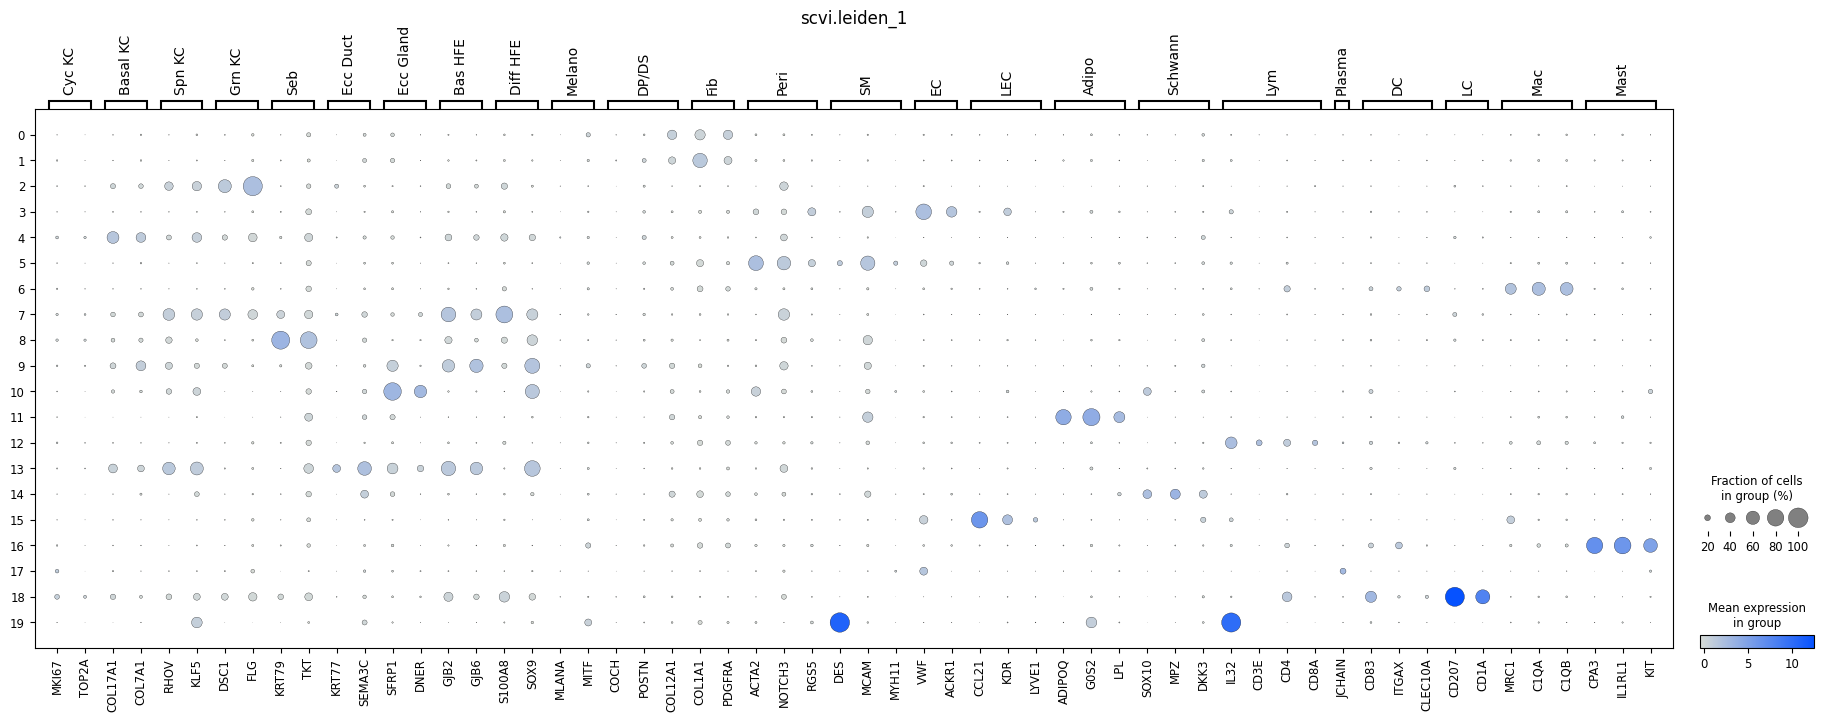

In [88]:
sc.pl.dotplot(adata, dotplot_marker_genes, groupby="scvi.leiden_1", dendrogram=False, title="scvi.leiden_1", cmap=gray2blue)

In [113]:
df = {
    "scvi.leiden_1": adata.obs["scvi.leiden_1"].values.categories,
    "cell_category": [
        "Stroma", "Stroma", "Epithelia", "Stroma", "Epithelia", "Stroma", "Immune", "Epithelia",
        "Epithelia", "Epithelia", "Epithelia", "Stroma", "Immune", "Epithelia", "Stroma", "Stroma",
        "Immune", "Immune", "Immune", "Stroma"
    ],
    "cell_type.broad": [
        "Fibro", "Fibro", "Grn KC", "EC", "Bas KC", "Peri", "Mac/DC", "Spn KC", "Seb", "HFE",
        "Ecc Gland", "Adipo", "Lym", "Ecc Duct", "Schwann", "LEC", "Mast", "Plasma", "LC", "Peri"
    ]
}
df = pd.DataFrame(df)

In [114]:
cluster_to_cell_type = df.set_index("scvi.leiden_1")["cell_type.broad"].to_dict()
# Assuming you have an AnnData object `adata` with `scvi.leiden_1` in `.obs`
adata.obs["cell_type.broad"] = adata.obs["scvi.leiden_1"].map(cluster_to_cell_type)

In [115]:
# Also add cell category (e.g., Immune, Stroma, etc.)
cluster_to_category = df.set_index("scvi.leiden_1")["cell_category"].to_dict()
adata.obs["cell_category"] = adata.obs["scvi.leiden_1"].map(cluster_to_category)

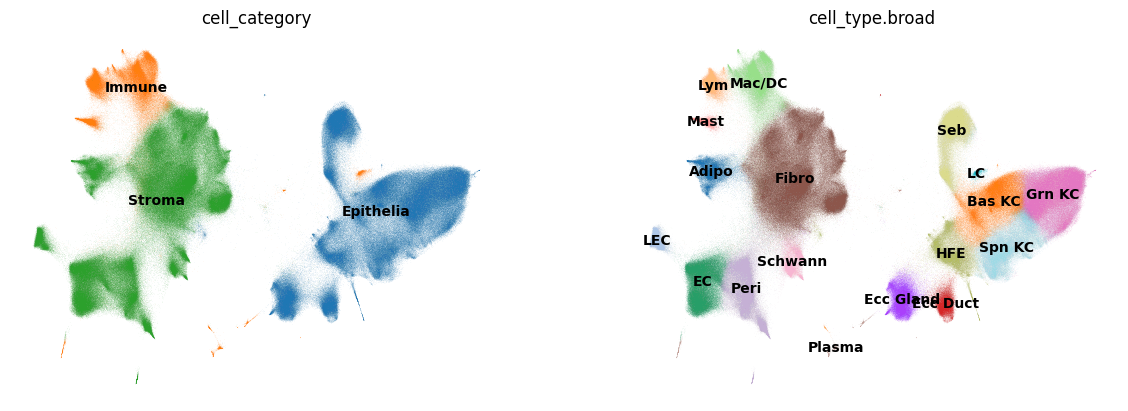

In [116]:
sc.pl.embedding(adata, basis='scvi_umap', color=['cell_category', "cell_type.broad"], legend_loc='on data', frameon=False)

In [117]:
adata.write_h5ad("../../data/merfish/BAYSOR/seurat_objects/ns-atlas.merfish_baysor.scvi_integrated.anndata.h5ad")
adata.obs.to_csv("../../data/merfish/BAYSOR/seurat_objects/ns-atlas.merfish_baysor.scvi_integrated.cell_metadata.csv")